In [35]:
#Implementation of a normal RNN with L1 regularization for comparision with the spatially embedded rnn.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import bct
import pandas as pd

In [36]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
hidden_size = 100
num_layers = 1
l1_lambda = 0.001

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset_mnist = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset_mnist = datasets.MNIST(root='../data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset_mnist, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset_mnist, batch_size=batch_size, shuffle=False)

    
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [37]:
def compute_modularity(recurrent_weight):
    thresh = np.quantile(recurrent_weight,.9)
    mask = recurrent_weight > thresh
    binary_weights = np.zeros(recurrent_weight.shape)
    binary_weights[mask] = 1
    _, mod = bct.modularity_und(binary_weights,gamma=1)
    return mod


def compute_small_worldness(recurrent_weight):
    thresh = np.quantile(recurrent_weight,.9)
    mask = recurrent_weight > thresh
    binary_weights = np.zeros(recurrent_weight.shape)
    binary_weights[mask] = 1
    A = binary_weights
    clu = np.mean(bct.clustering_coef_bu(A))
    pth = bct.efficiency_bin(A)
    # Run nperm null models
    nperm = 1000
    cluperm = np.zeros((nperm,1))
    pthperm = np.zeros((nperm,1))
    for perm in range(nperm):
        Wperm = np.random.rand(100,100)
        # Make it into a matrix
        Wperm = np.matrix(Wperm)
        # Make symmetrical
        Wperm = Wperm+Wperm.T
        Wperm = np.divide(Wperm,2)
        # Binarise
        threshold, upper, lower = .7,1,0
        Aperm = np.where(Wperm>threshold,upper,lower)
        # Take null model
        cluperm[perm] = np.mean(bct.clustering_coef_bu(Aperm))
        pthperm[perm] = bct.efficiency_bin(Aperm)
    # Take the average of the nulls
    clunull = np.mean(cluperm)
    pthnull = np.mean(pthperm)
    # Compute the small worldness
    smw = np.divide(np.divide(clu,clunull),np.divide(pth,pthnull))
    return smw

In [38]:
# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Initialize model, loss function, and optimizer
model = RNN(input_size=28, hidden_size=hidden_size, num_layers=num_layers, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def l1_reg(model,l1_lambda):
    return l1_lambda * sum([weight.abs().sum() for weight in model.parameters()])

def l2_reg(model,l1_lambda):
    #L2 regularization only on non recurrent weights -> SE1 takes care of regularization of recurrent parameters
    return l1_lambda * sum([weight.pow(2).sum() for name, weight in model.named_parameters()])

losses = []
modularity = []
small_worldness = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.squeeze(1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss += l2_reg(model,l1_lambda)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            losses.append(loss.item())
            numpy_weight = model.state_dict()["rnn.weight_hh_l0"].detach().cpu().numpy()
            modularity.append(compute_modularity(numpy_weight))
            small_worldness.append(compute_small_worldness(numpy_weight))

# Evaluation
model.eval()
correct = 0
total = 0
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.squeeze(1).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')


Epoch [1/20], Step [100/938], Loss: 1.4349


C:\Users\ankit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Epoch [1/20], Step [200/938], Loss: 1.1878


KeyboardInterrupt: 

### Graph Losses

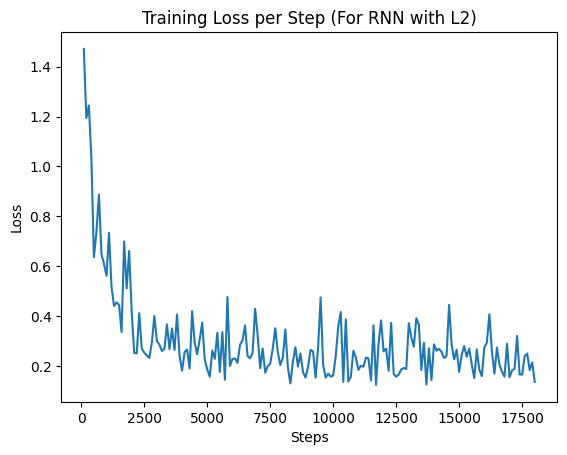

In [ ]:
plt.plot(np.array(range(1,len(losses)+1)) * 100,losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss per Step (For RNN with L2)")
plt.show()

### Modularity

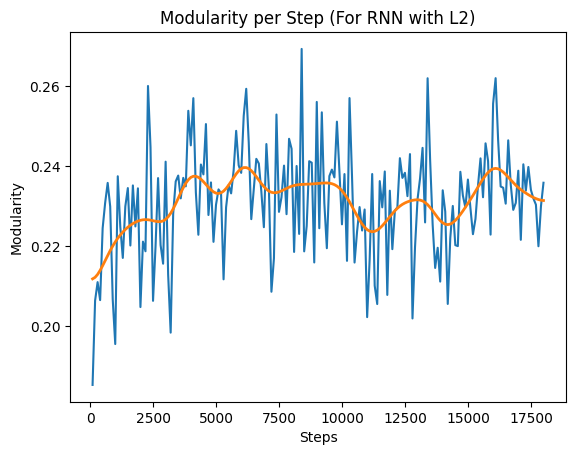

: 

In [ ]:
#Figure out a way to graph the small-worldness etc.
#Compute modularity of both forward layer or just rnn layer?

#Need to split it, create a function that calculates modularity, then graph the modularity as we go on.
from scipy.ndimage import gaussian_filter1d
smoothed_mod = gaussian_filter1d(modularity,5)
plt.plot(np.array(range(1,len(losses)+1)) * 100,modularity)
plt.plot(np.array(range(1,len(losses)+1)) * 100,smoothed_mod,linewidth=2)

plt.xlabel("Steps")
plt.ylabel("Modularity")
plt.title("Modularity per Step (For RNN with L2)")
plt.show()

### Small Worldness

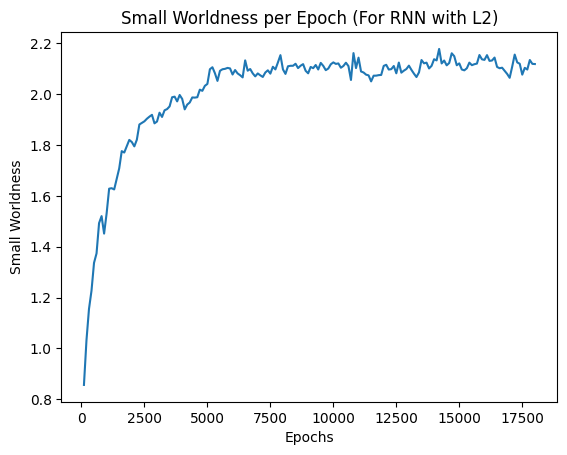

In [ ]:
#Figure out a way to graph the small-worldness etc.
#Compute modularity of both forward layer or just rnn layer?

#Need to split it, create a function that calculates modularity, then graph the modularity as we go on.
#Only once per epoch because its expensive
plt.plot(np.array(range(1,len(losses)+1)) * 100,small_worldness)
plt.xlabel("Epochs")
plt.ylabel("Small Worldness")
plt.title("Small Worldness per Epoch (For RNN with L2)")
plt.show()

In [ ]:
print(model.state_dict()["rnn.weight_hh_l0"].clone())

tensor([[ 0.2060, -0.1519,  0.0267,  ..., -0.2471,  0.0385,  0.0819],
        [-0.0176,  0.1041, -0.0321,  ...,  0.0254, -0.0258,  0.0566],
        [ 0.0276, -0.0680,  0.2722,  ..., -0.0066, -0.0446,  0.2004],
        ...,
        [-0.1642, -0.0939,  0.0684,  ...,  0.4091, -0.0337, -0.0224],
        [ 0.0678, -0.0264, -0.0315,  ...,  0.0373,  0.2789,  0.0413],
        [-0.0622, -0.0119,  0.1791,  ...,  0.0591, -0.0622,  0.3671]],
       device='cuda:0')


In [ ]:
#___RESULTS____
#97.51% - L2 regularization, hidden size = 180
#96.55% - L2 regularization, hidden size = 70
# 95.2%- L1 regularization l1, hidden size = 100
i = 0
for n, p in model.named_parameters():
    i += 1
    if p.requires_grad:
         print(p.data.shape)
         print(n)
         print(i)

#I want to look at rnn.weight_hh_l0, and rnn.weight_hh_l1. These are where the recurrent connections are present.


torch.Size([100, 28])
rnn.weight_ih_l0
1
torch.Size([100, 100])
rnn.weight_hh_l0
2
torch.Size([100])
rnn.bias_ih_l0
3
torch.Size([100])
rnn.bias_hh_l0
4
torch.Size([10, 100])
fc.weight
5
torch.Size([10])
fc.bias
6
